<a href="https://colab.research.google.com/github/AslantheAslan/Zachary-s-Karate-Club/blob/main/KarateClubGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:

!pip install git+git://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku


  Cloning git://github.com/deepmind/jraph.git to /tmp/pip-req-build-jvkf4wd9
  Running command git clone -q git://github.com/deepmind/jraph.git /tmp/pip-req-build-jvkf4wd9


In [132]:
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import numpy as onp
import networkx as nx
from typing import Tuple

In [133]:
def build_toy_graph():
  """Define a four node graph, each node has a scalar as its feature."""

  # Nodes are defined implicitly by their features.
  # We will add four nodes, each with a feature, e.g.
  # node 0 has feature [0.],
  # node 1 has featre [2.] etc.
  # len(node_features) is the number of nodes.
  node_features = jnp.array([[0.], [2.], [4.], [6.]])

  # We will now specify 5 directed edges connecting the nodes we defined above.
  # We define this with `senders` (source node indices) and `receivers`
  # (destination node indices).
  # For example, to add an edge from node 0 to node 1, we append 0 to senders,
  # and 1 to receivers.
  # We can do the same for all 5 edges:
  # 0 -> 1
  # 1 -> 2
  # 2 -> 0
  # 3 -> 0
  # 0 -> 3
  senders = jnp.array([0, 1, 2, 3, 0])
  receivers = jnp.array([1, 2, 0, 0, 3])

  # You can optionally add edge attributes to the 5 edges.
  edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])

  # We then save the number of nodes and the number of edges.
  # This information is used to make running GNNs over multiple graphs
  # in a GraphsTuple possible.
  n_node = jnp.array([4])
  n_edge = jnp.array([5])

  # Optionally you can add `global` information, such as a graph label.
  global_context = jnp.array([[1]]) # Same feature dimensions as nodes and edges.
  graph = jraph.GraphsTuple(
      nodes=node_features,
      edges=edges,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge,
      globals=global_context
      )
  return graph

In [134]:
graph = build_toy_graph()

In [135]:
print(graph.n_node, "\n",
      graph.n_edge, "\n",
      graph.nodes, "\n",
      graph.edges, "\n",
      graph.senders, "\n",
      graph.receivers, "\n",
      graph.globals)

[4] 
 [5] 
 [[0.]
 [2.]
 [4.]
 [6.]] 
 [[5.]
 [6.]
 [7.]
 [8.]
 [8.]] 
 [0 1 2 3 0] 
 [1 2 0 0 3] 
 [[1]]


In [136]:
def convert_jraph_to_networkx_graph(jraph_graph):
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph

def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple):
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

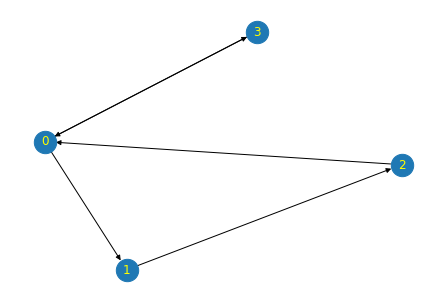

In [137]:
draw_jraph_graph_structure(graph)

In [138]:
def apply_simplified_gcn(graph: jraph.GraphsTuple):
  # Unpack GraphsTuple
  nodes, _, receivers, senders, _, _, _ = graph

  # 1. Update node features
  # For simplicity, we will first use an identify function here, and replace it
  # with a trainable MLP block later.
  update_node_fn = lambda nodes: nodes
  nodes = update_node_fn(nodes)

  # 2. Aggregate node features over nodes in neighborhood
  # Equivalent to jnp.sum(n_node), but jittable
  total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
  aggregate_nodes_fn = jax.ops.segment_sum

  # Compute new node features by aggregating messages from neighboring nodes
  nodes = tree.tree_map(lambda x: aggregate_nodes_fn(x[senders], receivers,
                                        total_num_nodes), nodes)
  out_graph = graph._replace(nodes=nodes)
  return out_graph

In [139]:
graph = build_toy_graph()

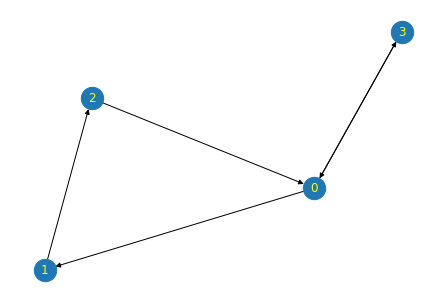

In [140]:
draw_jraph_graph_structure(graph)

In [141]:
out_graph = apply_simplified_gcn(graph)

In [142]:
out_graph.nodes

DeviceArray([[10.],
             [ 0.],
             [ 2.],
             [ 0.]], dtype=float32)

In [143]:
class MLP(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray):
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))

    mlp = hk.Sequential(layers)
    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(features=[8, 4])(x)

In [144]:
graph = build_toy_graph()

In [145]:
update_node_module = hk.without_apply_rng(hk.transform(update_node_fn))
params = update_node_module.init(jax.random.PRNGKey(42), graph.nodes)
out = update_node_module.apply(params, graph.nodes)

In [146]:
out

DeviceArray([[ 0.        ,  0.        ,  0.        ,  0.        ],
             [-0.14526582,  0.3303816 , -0.50791126, -0.643716  ],
             [-0.29053164,  0.6607632 , -1.0158225 , -1.287432  ],
             [-0.4357974 ,  0.99114484, -1.5237337 , -1.931148  ]],            dtype=float32)

In [147]:
def add_self_edges_fn(receivers, senders, total_num_nodes):
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

In [148]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(
    update_node_fn,
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges: bool = False,
    symmetric_normalization: bool = True):
  """Returns a method that applies a Graph Convolution layer.
  Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
  NOTE: This implementation does not add an activation after aggregation.
  If you are stacking layers, you may want to add an activation between
  each layer.
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_nodes_fn: function used to aggregates the sender nodes.
    add_self_edges: whether to add self edges to nodes in the graph as in the
      paper definition of GCN. Defaults to False.
    symmetric_normalization: whether to use symmetric normalization. Defaults
      to True.
  Returns:
    A method that applies a Graph Convolution layer.
  """
  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    # First pass nodes through the node updater.
    nodes = update_node_fn(nodes)
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      # In principle, a `GraphsTuple` should partition by n_edge, but in
      # this case it is not required since a GCN is agnostic to whether
      # the `GraphsTuple` is a batch of graphs or a single large graph.
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders, total_num_nodes)
    else:
      conv_senders = senders
      conv_receivers = receivers

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.
      count_edges = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      sender_degree = count_edges(conv_senders)
      receiver_degree = count_edges(conv_receivers)

      # Pre normalize by sqrt sender degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )
      # Aggregate the pre-normalized nodes.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      # Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )
    else:
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
    # pylint: enable=g-long-lambda
    return graph._replace(nodes=nodes)

  return _ApplyGCN

In [149]:
gcn_layer = GraphConvolution(
    update_node_fn=lambda n: MLP(features=[8, 4])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)

In [150]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-0.29652256,  0.6743886 , -1.0367694 , -1.3139795 ],
             [-0.07263289,  0.16519076, -0.25395557, -0.32185793],
             [-0.21789868,  0.4955723 , -0.76186675, -0.9655737 ],
             [-0.21789865,  0.49557233, -0.7618667 , -0.96557385]],            dtype=float32)

In [151]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a graph neural network with 3 GCN layers.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph

In [152]:
graph = build_toy_graph()
network = hk.without_apply_rng(hk.transform(gcn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

DeviceArray([[-0.32386124,  0.10707336],
             [-0.23884147,  0.07896456],
             [-0.19206831,  0.06350066],
             [-0.23884147,  0.07896456]], dtype=float32)

In [153]:
"""Zachary's karate club example.
From https://github.com/deepmind/jraph/blob/master/jraph/examples/zacharys_karate_club.py.
Here we train a graph neural network to process Zachary's karate club.
https://en.wikipedia.org/wiki/Zachary%27s_karate_club
Zachary's karate club is used in the literature as an example of a social graph.
Here we use a graphnet to optimize the assignments of the students in the
karate club to two distinct karate instructors (Mr. Hi and John A).
"""

def get_zacharys_karate_club() -> jraph.GraphsTuple:
  """Returns GraphsTuple representing Zachary's karate club."""
  social_graph = [
      (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
      (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
      (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
      (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
      (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
      (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
      (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
      (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
      (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
      (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
      (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
      (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
      (33, 31), (33, 32)]
  # Add reverse edges.
  social_graph += [(edge[1], edge[0]) for edge in social_graph]
  n_club_members = 34

  return jraph.GraphsTuple(
      n_node=jnp.asarray([n_club_members]),
      n_edge=jnp.asarray([len(social_graph)]),
      # One-hot encoding for nodes, i.e. argmax(nodes) = node index.
      nodes=jnp.eye(n_club_members),
      # No edge features.
      edges=None,
      globals=None,
      senders=jnp.asarray([edge[0] for edge in social_graph]),
      receivers=jnp.asarray([edge[1] for edge in social_graph]))

def get_ground_truth_assignments_for_zacharys_karate_club() -> jnp.ndarray:
  """Returns ground truth assignments for Zachary's karate club."""
  return jnp.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
                    0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [154]:
graph = get_zacharys_karate_club()

In [155]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 34
Number of edges: 156


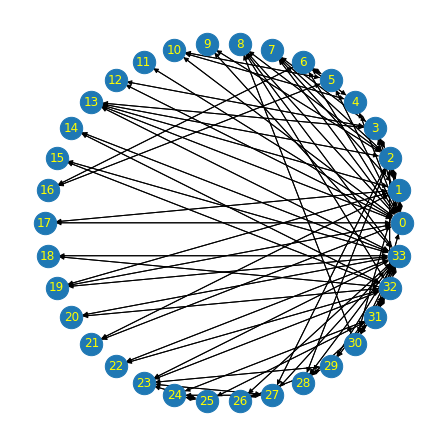

In [156]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

In [157]:
def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GCN for the karate club task.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2)) # output dim is 2 because we have 2 output classes.
  graph = gn(graph)
  return graph

In [158]:
def optimize_club(network, num_steps: int):
  """Solves the karate club problem by optimizing the assignments of students."""
  zacharys_karate_club = get_zacharys_karate_club()
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def predict(params):
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.argmax(decoded_graph.nodes, axis=1)

  @jax.jit
  def prediction_loss(params):
    decoded_graph = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_graph.nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params, opt_state):
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params):
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

  for step in range(num_steps):
    print(f"step {step} accuracy {accuracy(params).item():.2f}")
    params, opt_state = update(params, opt_state)

  return predict(params)

In [159]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
result = optimize_club(network, num_steps=30)
#optimize_club function gives the accuracy of 1.00 after 28 iterations
#however, harmonic_function gives the accuracy of 1.00 after 3 iterations

step 0 accuracy 0.06
step 1 accuracy 0.15
step 2 accuracy 0.35
step 3 accuracy 0.50
step 4 accuracy 0.59
step 5 accuracy 0.68
step 6 accuracy 0.71
step 7 accuracy 0.74
step 8 accuracy 0.74
step 9 accuracy 0.76
step 10 accuracy 0.76
step 11 accuracy 0.91
step 12 accuracy 0.91
step 13 accuracy 0.91
step 14 accuracy 0.91
step 15 accuracy 0.91
step 16 accuracy 0.94
step 17 accuracy 0.91
step 18 accuracy 0.91
step 19 accuracy 0.91
step 20 accuracy 0.94
step 21 accuracy 0.94
step 22 accuracy 0.94
step 23 accuracy 0.94
step 24 accuracy 0.97
step 25 accuracy 0.97
step 26 accuracy 0.97
step 27 accuracy 1.00
step 28 accuracy 1.00
step 29 accuracy 1.00


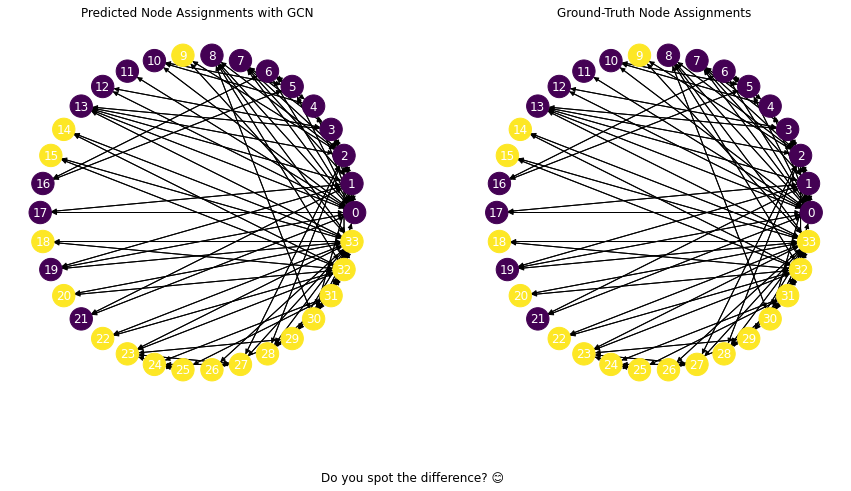

In [160]:
zacharys_karate_club = get_zacharys_karate_club()
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, node_color=result.tolist(), font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club()
ax2 = fig.add_subplot(122)
nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, node_color=gt_labels.tolist(), font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😊', y=-0.01)

plt.show()

In [161]:
######### GAT Implementation #########

# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn,
        attention_logit_fn,
        node_update_fn=None,
        add_self_edges=True):
  """Returns a method that applies a Graph Attention Network layer.
  Graph Attention message passing as described in
  https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
  jnp.array, may use edge features for computing attention weights, and
  ignore global features. It does not support nests.
  Args:
    attention_query_fn: function that generates attention queries
      from sender node features.
    attention_logit_fn: function that converts attention queries into logits for
      softmax attention.
    node_update_fn: function that updates the aggregated messages. If None,
      will apply leaky relu and concatenate (if using multi-head attention).
  Returns:
    A function that applies a Graph Attention layer.
  """
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph):
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders, total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(
        sent_attributes, received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(att_softmax_logits, segment_ids=receivers,
                                    num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)
  # pylint: enable=g-long-lambda
  return _ApplyGAT

In [162]:
def attention_logit_fn(sender_attr, receiver_attr, edges):
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return hk.Linear(1)(x)

gat_layer = GAT(
    attention_query_fn=lambda n: hk.Linear(8)(n),  # Applies W to the node features
    attention_logit_fn=attention_logit_fn,
    node_update_fn=None,
    add_self_edges=True,
)

In [163]:
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  def _attention_logit_fn( sender_attr, receiver_attr, edges):
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
    attention_query_fn=lambda n: hk.Linear(8)(n),
    attention_logit_fn=_attention_logit_fn,
    node_update_fn=None,
    add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
    attention_query_fn=lambda n: hk.Linear(8)(n),
    attention_logit_fn=_attention_logit_fn,
    node_update_fn=hk.Linear(2),
    add_self_edges=True)
  graph = gn(graph)
  return graph

In [164]:
network = hk.without_apply_rng(hk.transform(gat_definition))
result = optimize_club(network, num_steps=30)

step 0 accuracy 0.50
step 1 accuracy 0.94
step 2 accuracy 0.94
step 3 accuracy 0.94
step 4 accuracy 0.97
step 5 accuracy 0.97
step 6 accuracy 0.97
step 7 accuracy 0.97
step 8 accuracy 0.97
step 9 accuracy 0.97
step 10 accuracy 1.00
step 11 accuracy 1.00
step 12 accuracy 1.00
step 13 accuracy 0.97
step 14 accuracy 0.97
step 15 accuracy 0.97
step 16 accuracy 0.97
step 17 accuracy 0.97
step 18 accuracy 0.97
step 19 accuracy 0.97
step 20 accuracy 0.97
step 21 accuracy 0.97
step 22 accuracy 0.97
step 23 accuracy 0.97
step 24 accuracy 0.97
step 25 accuracy 0.97
step 26 accuracy 0.97
step 27 accuracy 0.97
step 28 accuracy 0.97
step 29 accuracy 0.97
